## Phase 3: Baseline Model Training 


**Objective**: Establish baseline performance for 3-class (Negative, Neutral, Positive) sentiment classification on the Bangla Sentiment Dataset without imbalance mitigation, using Logistic Regression, SVM, Naive Bayes (MultinomialNB), and Random Forest, with exhaustive hyperparameter tuning via GridSearchCV tailored to the dataset’s imbalance and visualizations (confusion matrices, ROC-AUC curves) to quantify class imbalance effects.

### Step 1: Load Preprocessed Data

- **Objective**: Load TF-IDF matrices and labels from Phase 2.

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import os
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


# Define paths
data_dir = "text_representation/"
files = {
    'tfidf_train': f"{data_dir}tfidf_train.npz",
    'tfidf_val': f"{data_dir}tfidf_val.npz",
    'tfidf_test': f"{data_dir}tfidf_test.npz",
    'labels_train': f"{data_dir}labels_train.csv",
    'labels_val': f"{data_dir}labels_val.csv",
    'labels_test': f"{data_dir}labels_test.csv"
}

# Check file existence
for name, path in files.items():
    if not os.path.exists(path):
        logging.error(f"Missing file: {path}")
        raise FileNotFoundError(f"Missing file: {path}")

# Load TF-IDF matrices
tfidf_train = sp.load_npz(files['tfidf_train'])
tfidf_val = sp.load_npz(files['tfidf_val'])
tfidf_test = sp.load_npz(files['tfidf_test'])
logging.info("TF-IDF matrices loaded successfully")

# Load labels
y_train = pd.read_csv(files['labels_train'], encoding='utf-8')['Label'].values
y_val = pd.read_csv(files['labels_val'], encoding='utf-8')['Label'].values
y_test = pd.read_csv(files['labels_test'], encoding='utf-8')['Label'].values
logging.info("Labels loaded successfully")

# Validate shapes
assert tfidf_train.shape[0] == len(y_train), "Train data mismatch"
assert tfidf_val.shape[0] == len(y_val), "Validation data mismatch"
assert tfidf_test.shape[0] == len(y_test), "Test data mismatch"
logging.info("Data shapes validated")

# Print shapes and distribution
print("TF-IDF Train Shape:", tfidf_train.shape)
print("Labels Train Shape:", y_train.shape)
print("Label Distribution (Train):\n", pd.Series(y_train).value_counts(normalize=True) * 100)

2025-06-23 11:04:28,126 - INFO - TF-IDF matrices loaded successfully
2025-06-23 11:04:28,133 - INFO - Labels loaded successfully
2025-06-23 11:04:28,134 - INFO - Data shapes validated


TF-IDF Train Shape: (6193, 5000)
Labels Train Shape: (6193,)
Label Distribution (Train):
 0    47.359922
2    29.081221
1    23.558857
Name: proportion, dtype: float64


### Step 2: Train Logistic Regression, SVM, Naive Bayes, and Random Forest

- **Objective**: Train baseline models on the imbalanced TF-IDF training set.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import joblib
from tqdm import tqdm

In [3]:
# Create output directory
os.makedirs("models/baseline_models", exist_ok=True)
logging.info("Output directory created: models/baseline_models")

2025-06-23 11:04:28,943 - INFO - Output directory created: models/baseline_models


In [4]:
# Initialize models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, multi_class='multinomial', penalty='l2', random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'NaiveBayes': MultinomialNB(),
    'RandomForest': RandomForestClassifier(random_state=42)
}

results = {} # store the performance of models
lb = LabelBinarizer()  # turns y_val into binary format for ROC-AUC

In [5]:
# Train and evaluate
for name, model in tqdm(models.items(), desc="Training Models"):
    try:
        # Train the model
        model.fit(tfidf_train, y_train)
        logging.info(f"{name} training completed")

        # Predict on validation set
        y_pred = model.predict(tfidf_val)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_val, y_pred, average='weighted'
        )
        f1_per_class = precision_recall_fscore_support(y_val, y_pred)[2]

        # ROC-AUC Score (One-vs-Rest strategy)
        y_val_bin = lb.fit_transform(y_val)
        y_pred_proba = model.predict_proba(tfidf_val)
        roc_auc = roc_auc_score(y_val_bin, y_pred_proba, multi_class='ovr')

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision_weighted': precision,
            'recall_weighted': recall,
            'f1_weighted': f1,
            'f1_per_class': f1_per_class,
            'roc_auc': roc_auc
        }

        # Save model to disk
        joblib.dump(model, f"models/baseline_models/{name}_baseline.joblib")
        logging.info(f"{name} model saved: {name}_baseline.joblib")

    except Exception as e:
        logging.error(f"Error training {name}: {str(e)}")
    

Training Models:   0%|          | 0/4 [00:00<?, ?it/s]/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
2025-06-23 11:04:29,760 - INFO - LogisticRegression training completed
2025-06-23 11:04:29,826 - INFO - LogisticRegression model saved: LogisticRegression_baseline.joblib
Training Models:  25%|██▌       | 1/4 [00:00<00:02,  1.22it/s]2025-06-23 11:05:28,237 - INFO - SVM training completed
2025-06-23 11:05:29,889 - INFO - SVM model saved: SVM_baseline.joblib
Training Models:  50%|█████     | 2/4 [01:00<01:11, 35.67s/it]2025-06-23 11:05:29,895 - INFO - NaiveBayes training completed
2025-06-23 11:05:29,914 - INFO - NaiveBayes model saved: NaiveBayes_baseline.joblib
2025-06-23 11:05:44,604 - INFO - RandomFore

In [6]:
# Save all tuning results to CSV
pd.DataFrame(results).to_csv("models/baseline_models/results.csv")
logging.info("results saved: results.csv")

2025-06-23 11:05:45,039 - INFO - results saved: results.csv


In [7]:
from tabulate import tabulate

# Print summary as a table
print(f"\nValidation Metrics:")
summary = [[name, metrics['accuracy'], metrics['f1_weighted'], metrics['roc_auc'], metrics['f1_per_class']]
           for name, metrics in results.items()]
print(tabulate(summary, headers=['Model', 'Accuracy', 'F1 Weighted', 'ROC-AUC', 'F1 per Class'], tablefmt='grid'))


Validation Metrics:
+--------------------+------------+---------------+-----------+------------------------------------+
| Model              |   Accuracy |   F1 Weighted |   ROC-AUC | F1 per Class                       |
+====================+============+===============+===========+====================================+
| LogisticRegression |   0.593548 |      0.57764  |  0.718815 | [0.68304094 0.46938776 0.49376559] |
+--------------------+------------+---------------+-----------+------------------------------------+
| SVM                |   0.610323 |      0.581136 |  0.718306 | [0.7063922  0.45864662 0.47645429] |
+--------------------+------------+---------------+-----------+------------------------------------+
| NaiveBayes         |   0.615484 |      0.579735 |  0.724139 | [0.71518987 0.44186047 0.47093023] |
+--------------------+------------+---------------+-----------+------------------------------------+
| RandomForest       |   0.583226 |      0.56308  |  0.712908 | [0.677

### Step 3: Hyperparameter Tuning with GridSearchCV

- **Objective**: Optimize hyperparameters using GridSearchCV with `f1_weighted` scoring.

In [8]:
from sklearn.model_selection import GridSearchCV

# # Grid parameter definitions
# param_grids = {
#     'LogisticRegression': {
#         'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Wider range for regularization
#         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
#         'multi_class': ['multinomial'],
#         'penalty': ['l1', 'l2'],  # Add l1 for feature selection (use 'saga' solver for l1)
#         'max_iter': [1000]
#     },
#     'SVM': {
#         'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  # Wider range
#         'kernel': ['linear', 'rbf', 'poly'],  # Add polynomial kernel
#         'gamma': ['scale', 'auto'],  # For rbf and poly kernels
#         'degree': [2, 3, 4]  # For poly kernel
#     },
#     'NaiveBayes': {
#         'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0]  # Finer and wider range
#     },
#     'RandomForest': {
#         'n_estimators': [50, 100, 200, 500],  # More trees
#         'max_depth': [None, 10, 20, 30],  # Deeper trees
#         'min_samples_split': [2, 5, 10],  # More options
#         'min_samples_leaf': [1, 2, 4],  # Prevent overfitting
#         'max_features': ['auto', 'sqrt', 'log2']  # Control feature sampling
#     }
# }

# Grid parameter definitions
param_grids = {
    'LogisticRegression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
        'penalty': ['l2'],
        'max_iter': [1000]
    },
    'SVM': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'kernel': ['linear', 'rbf']
    },
    'NaiveBayes': {
        'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],  # Prevent overfitting
    }
}

# Grid search loop
tuned_results = {}

for name, model in tqdm(models.items(), desc="Tuning Models (GridSearchCV)"):
    try:
        # Initialize GridSearchCV
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            scoring='f1_weighted',
            cv=5,
            n_jobs=-1,
            verbose=1
        )

        # Fit on training data
        grid_search.fit(tfidf_train, y_train)
        logging.info(f"{name} GridSearchCV completed")

        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(tfidf_val)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_val, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_val, y_pred, average='weighted'
        )
        f1_per_class = precision_recall_fscore_support(y_val, y_pred)[2]

        y_val_bin = lb.fit_transform(y_val)
        y_pred_proba = best_model.predict_proba(tfidf_val)
        roc_auc = roc_auc_score(y_val_bin, y_pred_proba, multi_class='ovr')

        # Store results
        tuned_results[name] = {
            'best_params': grid_search.best_params_,
            'accuracy': accuracy,
            'f1_weighted': f1,
            'f1_per_class': f1_per_class,
            'roc_auc': roc_auc
        }

        # Save model
        joblib.dump(best_model, f"models/baseline_models/{name}_tuned_grid.joblib")
        logging.info(f"{name} tuned model saved: {name}_tuned_grid.joblib")

    except Exception as e:
        logging.error(f"Error tuning {name}: {str(e)}")


Tuning Models (GridSearchCV):   0%|          | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 28 candidates, totalling 140 fits


/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/fahad/projects/personal/sentiment_analysis_bangla/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.w

Fitting 5 folds for each of 14 candidates, totalling 70 fits


2025-06-23 11:17:26,465 - INFO - SVM GridSearchCV completed
2025-06-23 11:17:28,204 - INFO - SVM tuned model saved: SVM_tuned_grid.joblib
Tuning Models (GridSearchCV):  50%|█████     | 2/4 [11:42<13:39, 409.74s/it]2025-06-23 11:17:28,391 - INFO - NaiveBayes GridSearchCV completed


Fitting 5 folds for each of 7 candidates, totalling 35 fits


2025-06-23 11:17:28,413 - INFO - NaiveBayes tuned model saved: NaiveBayes_tuned_grid.joblib
Tuning Models (GridSearchCV):  75%|███████▌  | 3/4 [11:43<03:42, 222.74s/it]

Fitting 5 folds for each of 81 candidates, totalling 405 fits


2025-06-23 11:22:14,966 - INFO - RandomForest GridSearchCV completed
2025-06-23 11:22:15,669 - INFO - RandomForest tuned model saved: RandomForest_tuned_grid.joblib
Tuning Models (GridSearchCV): 100%|██████████| 4/4 [16:30<00:00, 247.61s/it]


In [9]:
# Print summary as a table
print(f"\nTuned Validation Metrics:")
summary = [[name, metrics['accuracy'], metrics['f1_weighted'], metrics['roc_auc'], metrics['f1_per_class'], metrics['best_params']]
           for name, metrics in tuned_results.items()]
print(tabulate(summary, headers=['Model', 'Accuracy', 'F1 Weighted', 'ROC-AUC', 'F1 per Class ((Neg, Pos, Neu)', 'Best Params'], tablefmt='grid'))



Tuned Validation Metrics:
+--------------------+------------+---------------+-----------+------------------------------------+----------------------------------------------------------------------------------------------+
| Model              |   Accuracy |   F1 Weighted |   ROC-AUC | F1 per Class ((Neg, Pos, Neu)      | Best Params                                                                                  |
+====================+============+===============+===========+====================================+==============================================================================================+
| LogisticRegression |   0.593548 |      0.57764  |  0.718815 | [0.68304094 0.46938776 0.49376559] | {'C': 1, 'max_iter': 1000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'} |
+--------------------+------------+---------------+-----------+------------------------------------+-----------------------------------------------------------------------------------------

In [10]:
# Save all tuning results to CSV
pd.DataFrame(tuned_results).to_csv("models/baseline_models/tuned_results_grid.csv")
logging.info("Tuning results saved: tuned_results_grid.csv")

2025-06-23 11:22:15,770 - INFO - Tuning results saved: tuned_results_grid.csv


### Step 5: Evaluate on Test Set

- **Objective**: Evaluate tuned models on test set with confusion matrices and ROC-AUC curves.

Evaluating Test Set:   0%|          | 0/4 [00:00<?, ?it/s]2025-06-23 11:22:15,943 - INFO - Loaded model: LogisticRegression_tuned_grid.joblib


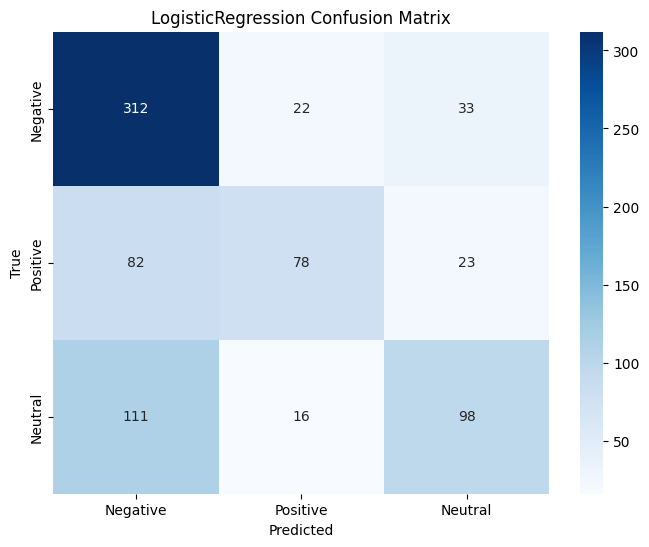

2025-06-23 11:22:16,520 - INFO - Saved confusion matrix: LogisticRegression_cm.png


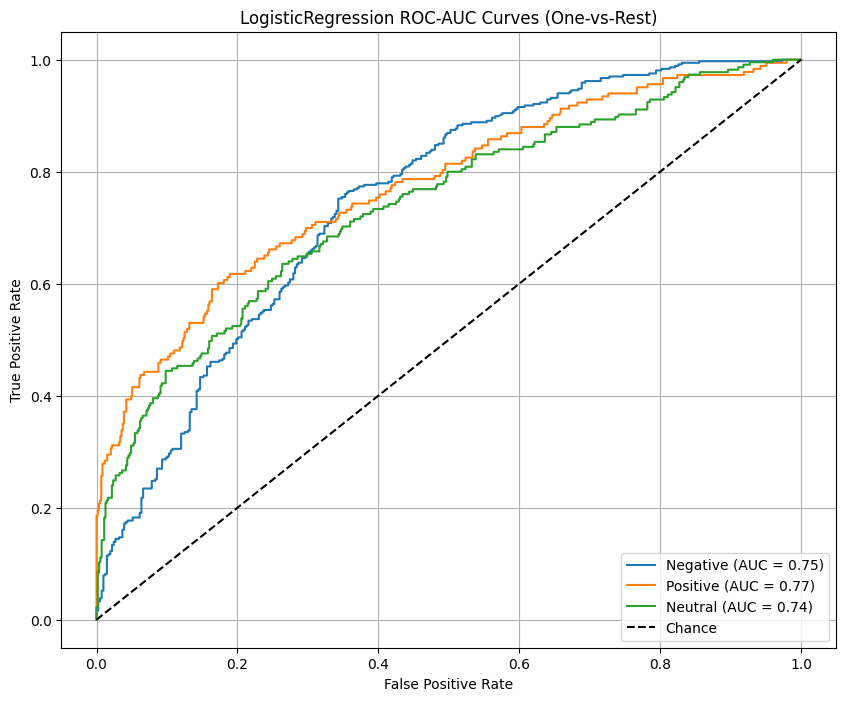

2025-06-23 11:22:16,970 - INFO - Saved ROC-AUC plot: LogisticRegression_roc_auc.png
Evaluating Test Set:  25%|██▌       | 1/4 [00:01<00:03,  1.04s/it]2025-06-23 11:22:16,983 - INFO - Loaded model: SVM_tuned_grid.joblib


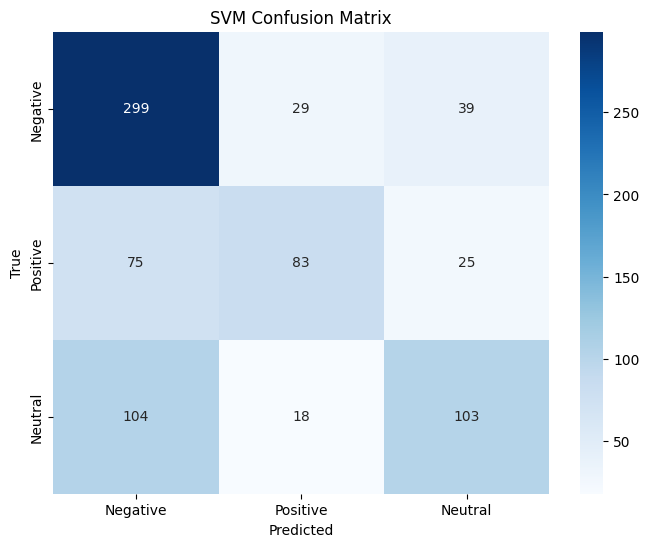

2025-06-23 11:22:19,097 - INFO - Saved confusion matrix: SVM_cm.png


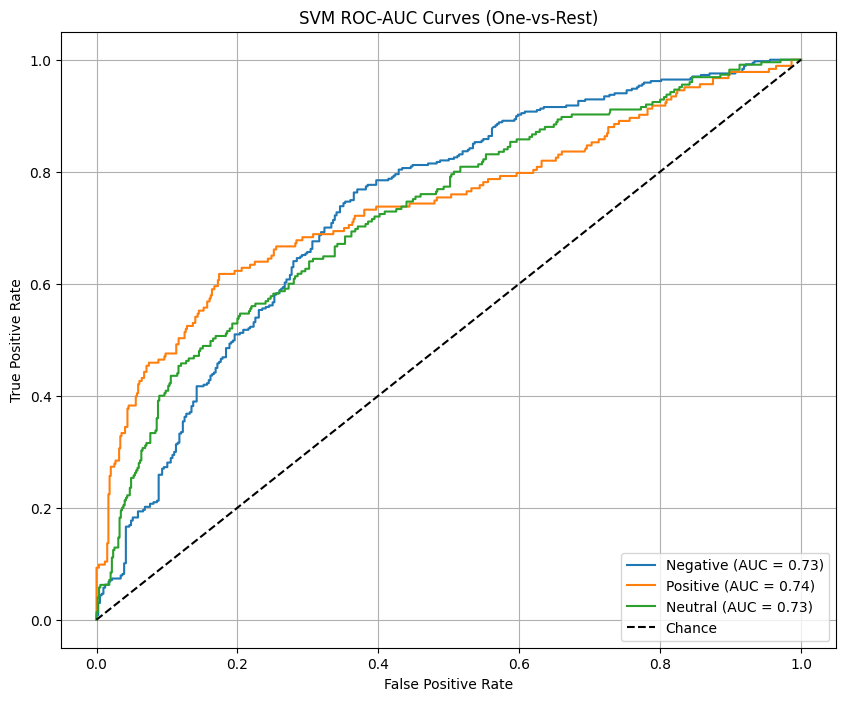

2025-06-23 11:22:19,612 - INFO - Saved ROC-AUC plot: SVM_roc_auc.png
Evaluating Test Set:  50%|█████     | 2/4 [00:03<00:03,  1.98s/it]2025-06-23 11:22:19,616 - INFO - Loaded model: NaiveBayes_tuned_grid.joblib


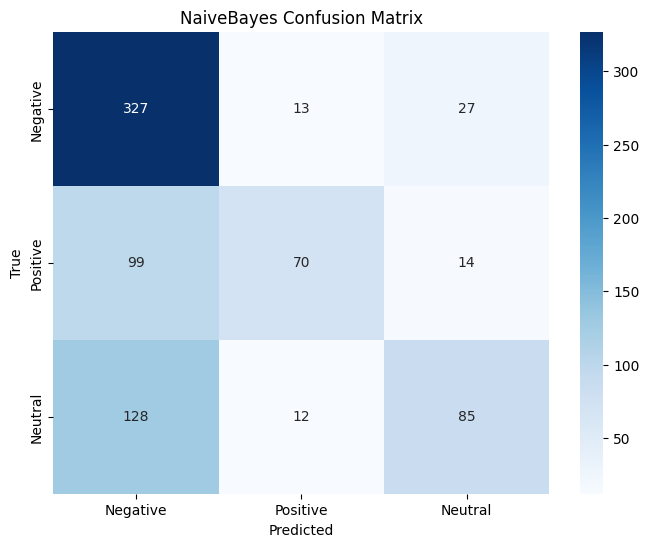

2025-06-23 11:22:19,974 - INFO - Saved confusion matrix: NaiveBayes_cm.png


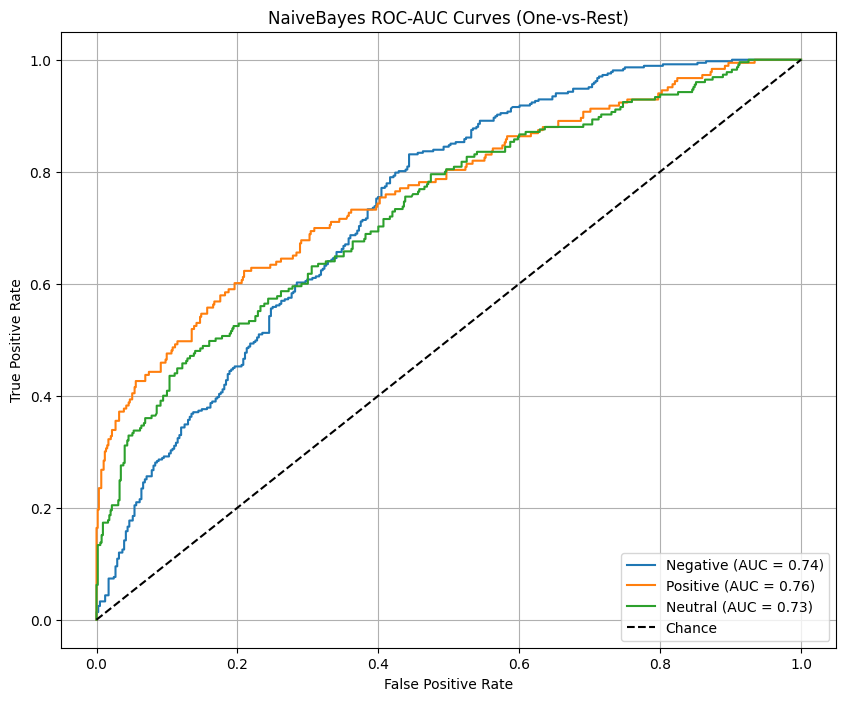

2025-06-23 11:22:20,419 - INFO - Saved ROC-AUC plot: NaiveBayes_roc_auc.png
Evaluating Test Set:  75%|███████▌  | 3/4 [00:04<00:01,  1.44s/it]2025-06-23 11:22:20,749 - INFO - Loaded model: RandomForest_tuned_grid.joblib


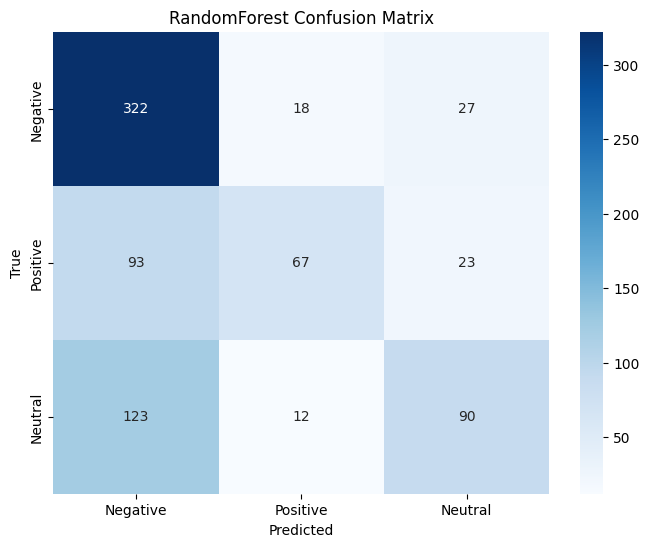

2025-06-23 11:22:21,674 - INFO - Saved confusion matrix: RandomForest_cm.png


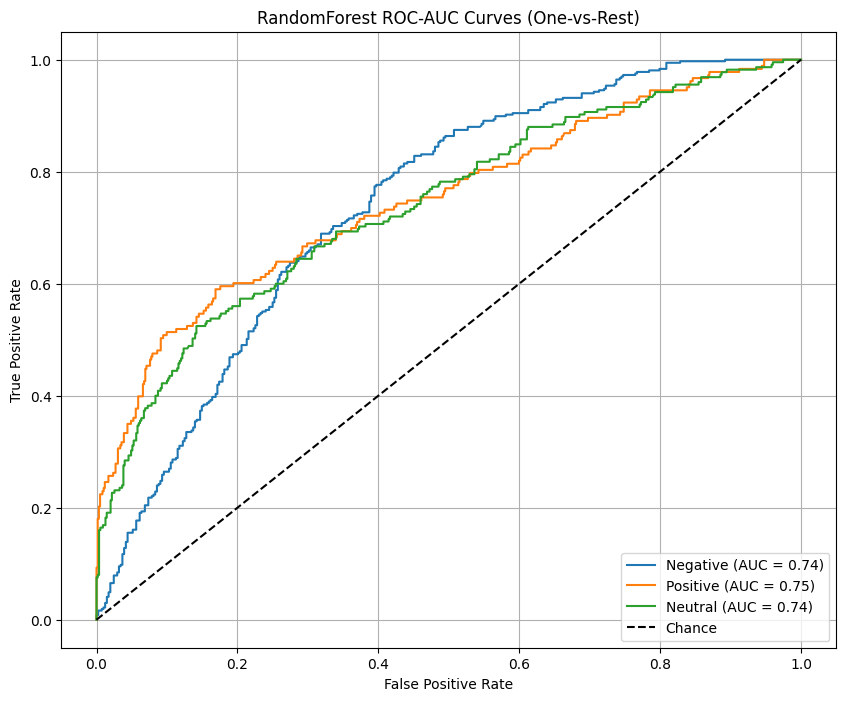

2025-06-23 11:22:22,144 - INFO - Saved ROC-AUC plot: RandomForest_roc_auc.png
Evaluating Test Set: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]
2025-06-23 11:22:22,153 - INFO - Test results saved: test_results.csv


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_recall_fscore_support
)
import numpy as np
import pandas as pd
import joblib
from tqdm import tqdm
import logging

# Define class names
class_names = ['Negative', 'Positive', 'Neutral']

# Evaluate on test set
test_results = {}

for name in tqdm(['LogisticRegression', 'SVM', 'NaiveBayes', 'RandomForest'], desc="Evaluating Test Set"):
    try:
        # Load model
        model = joblib.load(f"models/baseline_models/{name}_tuned_grid.joblib")
        logging.info(f"Loaded model: {name}_tuned_grid.joblib")

        # Predict
        y_pred = model.predict(tfidf_test)

        # Compute metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred, average='weighted'
        )
        f1_per_class = precision_recall_fscore_support(y_test, y_pred)[2]
        y_test_bin = lb.fit_transform(y_test)
        y_pred_proba = model.predict_proba(tfidf_test)
        roc_auc = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')

        test_results[name] = {
            'accuracy': accuracy,
            'f1_weighted': f1,
            'f1_per_class': f1_per_class,
            'roc_auc': roc_auc
        }

        # Confusion matrix plot
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names
        )
        plt.title(f"{name} Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.savefig(f"models/baseline_models/{name}_cm.png")
        plt.show()
        plt.close()
        logging.info(f"Saved confusion matrix: {name}_cm.png")

        # ROC-AUC curves (one-vs-rest)
        plt.figure(figsize=(10, 8))
        for i in range(len(class_names)):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc:.2f})")
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{name} ROC-AUC Curves (One-vs-Rest)")
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.savefig(f"models/baseline_models/{name}_roc_auc.png")
        plt.show()
        plt.close()
        logging.info(f"Saved ROC-AUC plot: {name}_roc_auc.png")

    except Exception as e:
        logging.error(f"Error evaluating {name}: {str(e)}")

# Save test results
pd.DataFrame(test_results).to_csv("models/baseline_models/test_results.csv")
logging.info("Test results saved: test_results.csv")

In [12]:
# Print summary as a table
print(f"\nTest Metrics:")
summary = [[name, metrics['accuracy'], metrics['f1_weighted'], metrics['roc_auc'], metrics['f1_per_class']]
           for name, metrics in test_results.items()]
print(tabulate(summary, headers=['Model', 'Accuracy', 'F1 Weighted', 'ROC-AUC', 'F1 per Class ((Neg, Pos, Neu)'], tablefmt='grid'))



Test Metrics:
+--------------------+------------+---------------+-----------+------------------------------------+
| Model              |   Accuracy |   F1 Weighted |   ROC-AUC | F1 per Class ((Neg, Pos, Neu)      |
+====================+============+===============+===========+====================================+
| LogisticRegression |   0.629677 |      0.612208 |  0.753958 | [0.71559633 0.52173913 0.5171504 ] |
+--------------------+------------+---------------+-----------+------------------------------------+
| SVM                |   0.625806 |      0.612925 |  0.734816 | [0.70769231 0.53035144 0.5255102 ] |
+--------------------+------------+---------------+-----------+------------------------------------+
| NaiveBayes         |   0.621935 |      0.595792 |  0.744348 | [0.71009772 0.50359712 0.48433048] |
+--------------------+------------+---------------+-----------+------------------------------------+
| RandomForest       |   0.618065 |      0.593155 |  0.743115 | [0.71160221 

In [13]:
# Update README
with open("models/baseline_models/README.txt", "w", encoding='utf-8') as f:
    f.write(
        "Baseline Model Outputs:\n"
        "- *_baseline.joblib: Initial trained models\n"
        "- *_tuned_grid.joblib: Tuned models (GridSearchCV, f1_weighted optimized)\n"
        "- tuned_results_grid.csv: Tuning results\n"
        "- test_results.csv: Test set metrics\n"
        "- *_cm.png: Confusion matrix plots\n"
        "- *_roc_auc.png: ROC-AUC curve plots"
    )

logging.info("README updated")

2025-06-23 11:22:22,212 - INFO - README updated


## Comparison

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Load all results
baseline = pd.read_csv("models/baseline_models/results.csv", index_col=0).T             # original
tuned_val = pd.read_csv("models/baseline_models/tuned_results_grid.csv", index_col=0).T  # or tuned_results_grid.csv
tuned_test = pd.read_csv("models/baseline_models/test_results.csv", index_col=0).T  # or test_results.csv

# Rename columns for clarity
baseline = baseline.add_suffix('_baseline')
tuned_val = tuned_val.add_suffix('_val')
tuned_test = tuned_test.add_suffix('_test')

# Merge all
comparison_df = pd.concat([baseline, tuned_val, tuned_test], axis=1)

In [15]:
comparison_df.head()

,accuracy_baseline,precision_weighted_baseline,recall_weighted_baseline,f1_weighted_baseline,f1_per_class_baseline,roc_auc_baseline,best_params_val,accuracy_val,f1_weighted_val,f1_per_class_val,roc_auc_val,accuracy_test,f1_weighted_test,f1_per_class_test,roc_auc_test
LogisticRegression,0.5935483870967742,0.5934420869838638,0.5935483870967742,0.5776403089462474,[0.68304094 0.46938776 0.49376559],0.7188149575342876,"{'C': 1, 'max_iter': 1000, 'multi_class': 'mul...",0.5935483870967742,0.5776403089462474,[0.68304094 0.46938776 0.49376559],0.7188149575342876,0.6296774193548387,0.612207681458976,[0.71559633 0.52173913 0.5171504 ],0.7539578154887493
SVM,0.6103225806451613,0.6347830205235231,0.6103225806451613,0.5811361084580383,[0.7063922 0.45864662 0.47645429],0.7183062102314249,"{'C': 10, 'kernel': 'rbf'}",0.5935483870967742,0.5817237043525518,[0.6811071 0.49180328 0.49275362],0.7081465519039405,0.6258064516129033,0.61292540121353,[0.70769231 0.53035144 0.5255102 ],0.7348161708242125
NaiveBayes,0.6154838709677419,0.6533770747941617,0.6154838709677419,0.5797347754660184,[0.71518987 0.44186047 0.47093023],0.7241385680145109,{'alpha': 0.5},0.6167741935483871,0.5934538948870072,[0.71061453 0.47826087 0.49604222],0.7264523501344674,0.6219354838709678,0.5957916071584985,[0.71009772 0.50359712 0.48433048],0.7443484209937052
RandomForest,0.5832258064516129,0.5856450670029583,0.5832258064516129,0.5630795764964753,[0.67730901 0.45296167 0.46632124],0.7129075382796214,"{'max_depth': None, 'min_samples_leaf': 1, 'mi...",0.5780645161290323,0.5542696842520165,[0.67410714 0.44599303 0.44686649],0.7180300237733568,0.6180645161290322,0.5931554665650118,[0.71160221 0.47857143 0.49315068],0.7431150576941293


In [16]:
# Keep only relevant columns
metrics = ['accuracy', 'f1_weighted', 'roc_auc']
columns = []
for metric in metrics:
    columns.extend([
        f"{metric}_baseline",
        f"{metric}_val",
        f"{metric}_test"
    ])
selected = comparison_df[columns]

In [17]:
# Print as table
print("\n===== Baseline vs Tuned (Validation) vs Tuned (Test) =====\n")
print(tabulate(selected, headers='keys', tablefmt='grid', floatfmt=".4f"))

# Save to CSV
selected.to_csv("models/baseline_models/comparison_all_transposed.csv")


===== Baseline vs Tuned (Validation) vs Tuned (Test) =====

+--------------------+---------------------+----------------+-----------------+------------------------+-------------------+--------------------+--------------------+---------------+----------------+
|                    |   accuracy_baseline |   accuracy_val |   accuracy_test |   f1_weighted_baseline |   f1_weighted_val |   f1_weighted_test |   roc_auc_baseline |   roc_auc_val |   roc_auc_test |
+====================+=====================+================+=================+========================+===================+====================+====================+===============+================+
| LogisticRegression |              0.5935 |         0.5935 |          0.6297 |                 0.5776 |            0.5776 |             0.6122 |             0.7188 |        0.7188 |         0.7540 |
+--------------------+---------------------+----------------+-----------------+------------------------+-------------------+---------------

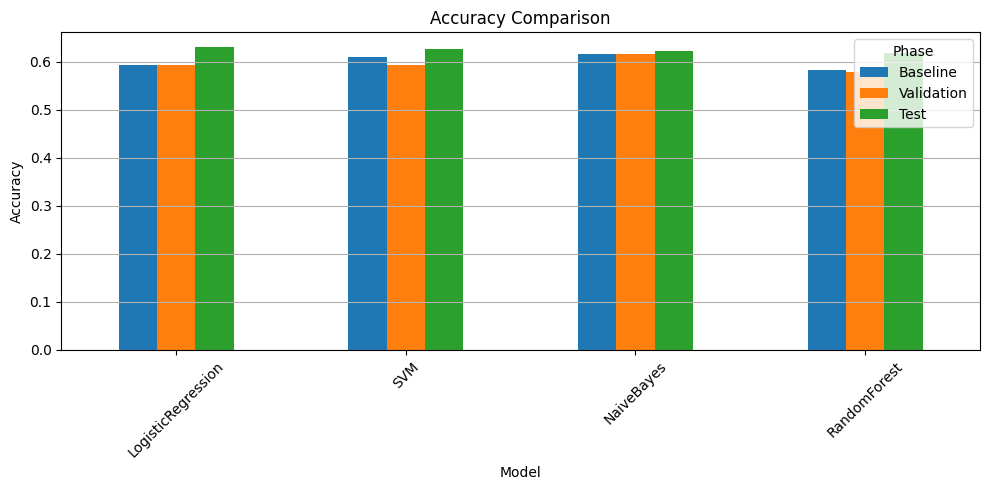

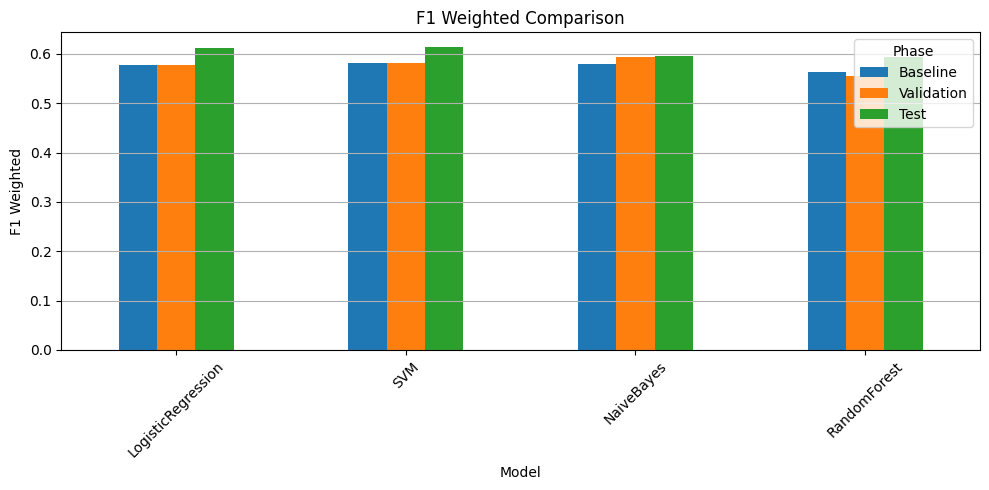

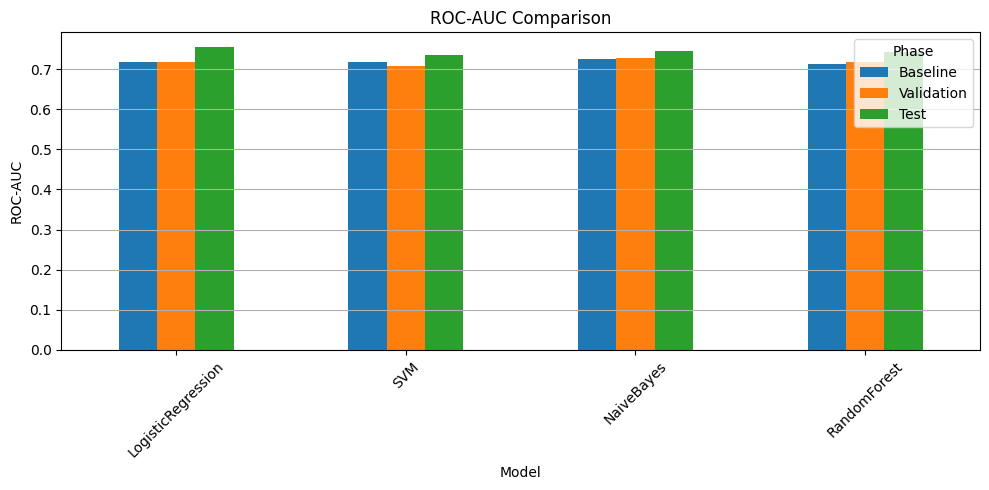

✅ Plots saved as:
 - models/baseline_models/compare_all_accuracy.png
 - models/baseline_models/compare_all_f1_weighted.png
 - models/baseline_models/compare_all_roc_auc.png


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
df = pd.read_csv("models/baseline_models/comparison_all_transposed.csv", index_col=0)

# Define metrics to plot
metrics = ['accuracy', 'f1_weighted', 'roc_auc']
metric_labels = {
    'accuracy': 'Accuracy',
    'f1_weighted': 'F1 Weighted',
    'roc_auc': 'ROC-AUC'
}

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 5))
    
    # Extract data for the metric across baseline, val, test
    data = df[[f"{metric}_baseline", f"{metric}_val", f"{metric}_test"]]
    data.columns = ['Baseline', 'Validation', 'Test']
    
    # Bar plot
    data.plot(kind='bar', ax=plt.gca())
    plt.title(f"{metric_labels[metric]} Comparison")
    plt.ylabel(metric_labels[metric])
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.legend(title="Phase")
    plt.tight_layout()
    plt.savefig(f"models/baseline_models/compare_all_{metric}.png")
    plt.show()
    plt.close()

print("✅ Plots saved as:")
for metric in metrics:
    print(f" - models/baseline_models/compare_all_{metric}.png")
